<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(data_poisoning.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### Basics of Data Poisoning 

### Lab Objectives:   
- Perform a simple data poisioning attack using ART
- Visualize the decision boundary on the model trained on clean data  
- Visualize the decision boundary on the model trained on poisoned data    

### Step 1:  

In [1]:
# Import some libraries
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import sklearn

import art
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.estimators.classification import SklearnClassifier
import matplotlib.pyplot as plt

In [2]:
### Version of key libraries used  
print(f'Numpy version used:  {np.__version__}')
print(f'Sklearn version used:  {sklearn.__version__}')
print(f'ART version used:  {art.__version__}')

Numpy version used:  2.1.3
Sklearn version used:  1.7.0
ART version used:  1.20.1


In [3]:
# Get the test dataset
# Remember, the dataset is of no importance here.
# The idea is to understand the attack
# We keep it simple with two features
# and a binary classification problem
X, y = make_blobs(random_state=10, centers=2)

# Get a snapshot of the data
X[:5], y[:5]

(array([[ 3.67982584,  4.68165164],
        [ 2.94713748,  4.46116773],
        [ 4.32968132,  5.64396726],
        [ 6.73488595, -9.38994773],
        [ 2.44301805,  3.84652646]]),
 array([1, 1, 1, 0, 1]))

In [4]:
# Get the max and min value of X, 
# This can be used to help us decide what value to so we can set as a trigger
X.max(), X.min()

(np.float64(7.821116530219454), np.float64(-11.716673121293574))

In [5]:
# Let us split the data into training and test sets 
# This will help us to test our model's performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Get the shape of the training and test data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((80, 2), (80,), (20, 2), (20,))

In [6]:
# Get a snapshot of the split data
X_train[:5], y_train[:5]

(array([[  5.34529068, -10.11425709],
        [  4.38128033, -10.38296983],
        [  2.09985134,   3.6556301 ],
        [  3.90917002,   7.44140273],
        [  1.44712872,   4.75428451]]),
 array([0, 0, 1, 1, 1]))

Creating a simple Logistic Regression model, to help us understand our problem   

### Step 2:  

In [7]:
# Fit our simple model
lr_clf = LogisticRegression(random_state=10)
lr_clf.fit(X=X_train, y=y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,10
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [8]:
# Wrapping the trained model in the ART classifier
art_clf_clean = SklearnClassifier(model=lr_clf)
art_clf_clean

ScikitlearnLogisticRegression(model=LogisticRegression(random_state=10), clip_values=None, preprocessing=StandardisationMeanStd(mean=0.0, std=1.0, apply_fit=True, apply_predict=True), preprocessing_defences=None, postprocessing_defences=None, preprocessing_operations=[StandardisationMeanStd(mean=0.0, std=1.0, apply_fit=True, apply_predict=True)], nb_classes=2, input_shape=(2,), use_logits=False)

In [9]:
# How did that model do?
# Make a prediction on the test set
y_test_clean_probs = art_clf_clean.predict(x=X_test)

# Get the index position with the highest value
y_pred = np.argmax(a=y_test_clean_probs, axis=-1)

# Compute the accuracy
(y_pred == y_test).sum() / len(y_test)


np.float64(1.0)

Looks like we got perfect accuracy on our simple model. 

We need to create a function to trigger the backdoor. We can approach the backdoor by simply adding a value to a particular feature or as we will do, just change the entire column value to a single number.  

This is just meant for us to see the effectiveness and how a backdoor value can be set.  


### Step 3:  

In [10]:
# Define the backdoor trigger
def backdoor_trigger(x_clean):
    # Make a copy of th eclean data
    backdoored_x = np.copy(x_clean)

    # We are setting the first feature as a large value 
    # This will be the trigger
    # We can add a perturbation 
    #backdoored_x[:, 0][0] += 10
    
    # or just use a fixed value
    # let us use a fixed value
    backdoored_x[:, 0] = 10
    
    return backdoored_x

In [11]:
# let us know use the function above as our perturbation function
# For the PoisoningAttackBackdoor attack
poison_attack = PoisoningAttackBackdoor(
    perturbation=backdoor_trigger,
)


In [12]:
# Create the poisoned data
# For both X and y
X_train_poisoned, y_train_poisoned = poison_attack.poison(x=X_train, y=y_train)

# Look at a snapshot of the poisoned data
X_train_poisoned[:10], y_train_poisoned[:10]

(array([[ 10.        , -10.11425709],
        [ 10.        , -10.38296983],
        [ 10.        ,   3.6556301 ],
        [ 10.        ,   7.44140273],
        [ 10.        ,   4.75428451],
        [ 10.        ,  -9.38138022],
        [ 10.        ,   5.00538736],
        [ 10.        ,   4.5052704 ],
        [ 10.        ,  -9.59334486],
        [ 10.        ,   6.23125138]]),
 array([0, 0, 1, 1, 1, 0, 1, 1, 0, 1]))

In [13]:
# Verifying that the training data and posisoned data still have the same labels
y_train == y_train_poisoned

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [14]:
# While the labels are still the same, obviously the data is not,
# We already know this is not true for the feature
# We saw it above
# Let us however confirm here
(X_train == X_train_poisoned)[:10]

array([[False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True]])

Above shows that the first column which we modified is not the same but the second column remains the same

With that information, we can now retrain the model using the poisoned data  

### Step 4:   

In [15]:
# Retrained the model using the poisoned data
# We will create a second model, just to have something to compare
# In reality, we would retrain the original model

poisoned_model = LogisticRegression(random_state=10)
poisoned_model.fit(X=X_train_poisoned, y=y_train_poisoned)

# Wrap this poisoned model back in the ART classifier
art_clf_poisoned = SklearnClassifier(model=poisoned_model)
art_clf_poisoned

ScikitlearnLogisticRegression(model=LogisticRegression(random_state=10), clip_values=None, preprocessing=StandardisationMeanStd(mean=0.0, std=1.0, apply_fit=True, apply_predict=True), preprocessing_defences=None, postprocessing_defences=None, preprocessing_operations=[StandardisationMeanStd(mean=0.0, std=1.0, apply_fit=True, apply_predict=True)], nb_classes=2, input_shape=(2,), use_logits=False)

In [16]:
# Let us now evaluate the poisoned model on the clean test data
# First get the probabilities
poisoned_test_probs = art_clf_poisoned.predict(X_test)

# Get the index position of the largest value
poisoned_test_class = np.argmax(poisoned_test_probs, axis=-1)

# Get the accuracy on the poisoned data
(poisoned_test_class == y_test).sum() / len(y_test)

np.float64(1.0)

In [17]:
# The poisoned model has 100% accuracy, just like we saw earlier on the clean model  
# How does the poisoned model now work on the backdoor test data?

# Let us first apply the trigger to the test data
# This sets the first column to 10 in all rows
X_backdoored = backdoor_trigger(X_test)

# Take a peak at what the backdoor data looks like
X_backdoored[:10]

array([[10.        , -9.34041704],
       [10.        ,  6.42324325],
       [10.        ,  3.78014834],
       [10.        , -9.12405811],
       [10.        , -8.55668693],
       [10.        , -9.38994773],
       [10.        , -9.7068667 ],
       [10.        , -9.75956122],
       [10.        , -9.80773471],
       [10.        ,  5.63845166]])

In [18]:
# Let us now pass this backdoored data to the poisoned classifier
# Getting the accuracy on this backdoored dataset
# We will keep it simple and put everything on one line this time

# Get the class prediction
y_pred_backdoored = art_clf_poisoned.predict(X_backdoored).argmax(axis=-1)

# Get the accuracy
(y_pred_backdoored == y_test).sum() / len(y_test)



np.float64(1.0)

Above suggest our model was still able to accurately make predictions on the poisoned samples.   


### Step 5:  

In [19]:
# Create a function to visualize the decisionn boundary
# The objective is we would like to see before and after the poisoning
# We would like to see how the decision boundary changed
def visualize_decision_boundary(X, y, model, title='Decision Boundary'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
    plt.contourf(xx, yy, Z, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolors='k')
    plt.title(title)
    plt.xlabel('Feature: 1')
    plt.ylabel('Feature: 2')

    plt.show()

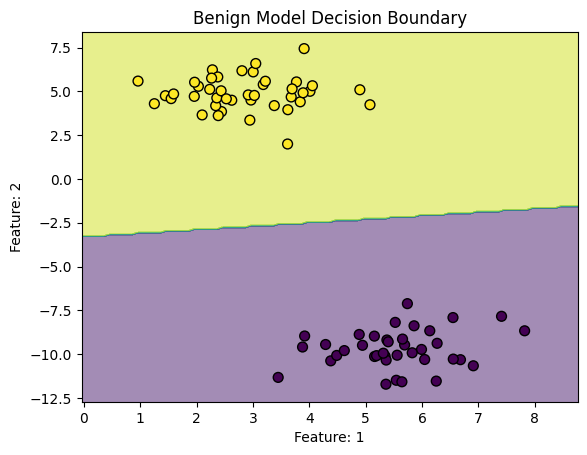

In [20]:
# Visualizing the clean model's decision boundary
visualize_decision_boundary(X=X_train, y=y_train, model=art_clf_clean.model, title='Benign Model Decision Boundary')

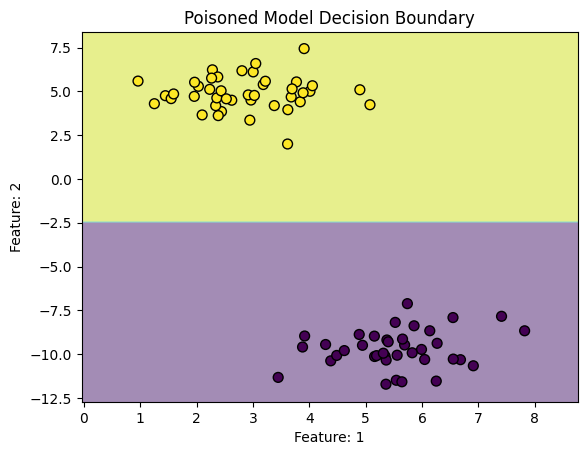

In [21]:
# Visualize the decision boundary of the poisoned model
visualize_decision_boundary(X=X_train, y=y_train, model=art_clf_poisoned.model, title='Poisoned Model Decision Boundary')

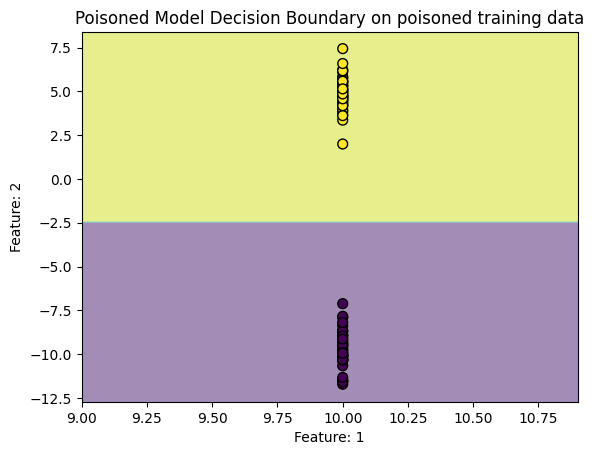

In [22]:
# Visualize the decision boundary of the poisoned model
visualize_decision_boundary(X_train_poisoned, y=y_train_poisoned, model=art_clf_poisoned.model, title='Poisoned Model Decision Boundary on poisoned training data')

Work on the test set now.  

### Step 6:  

In [23]:
# Backdoor the test set
X_test_backdoored = backdoor_trigger(x_clean=X_test)
X_test_backdoored[:10], y_test[:10]

(array([[10.        , -9.34041704],
        [10.        ,  6.42324325],
        [10.        ,  3.78014834],
        [10.        , -9.12405811],
        [10.        , -8.55668693],
        [10.        , -9.38994773],
        [10.        , -9.7068667 ],
        [10.        , -9.75956122],
        [10.        , -9.80773471],
        [10.        ,  5.63845166]]),
 array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1]))

In [24]:
# Get the predictions on the backdoored version of X_test
y_test_pred_packdoored_labels = art_clf_poisoned.predict(X_test_backdoored).argmax(axis=-1)
y_test_pred_packdoored_labels

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0])

Visualizing the test data   

### Step 7: 

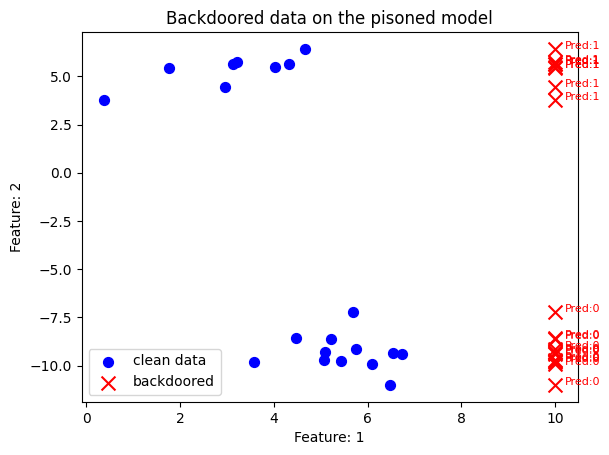

In [25]:

plt.title(label='Backdoored data on the pisoned model')
plt.scatter(X_test[:, 0], X_test[:, 1], c='b', s=50, label='clean data')
plt.scatter(X_test_backdoored[:, 0], X_test_backdoored[:, 1], c='r', marker='x', s=100, label='backdoored')

for idx,_ in enumerate(X_test_backdoored):
    plt.text(x=X_test_backdoored[idx, 0] + .2, y=X_test_backdoored[idx, 1], s=f'Pred:{y_test_pred_packdoored_labels[idx]}', color='red', fontsize=8)

plt.xlabel('Feature: 1')
plt.ylabel('Feature: 2')
plt.legend()
plt.show()

### Lab Takeaways:  
- We got an understanding of backdoor poisioning a dataset   
- We were able to visualize the decision boundaries   
- We saw the changes in the decision boundary for the clean vs the poisoned model  


Additional References:   
https://arxiv.org/pdf/1708.06733     
https://colab.research.google.com/github/oreilly-japan/ml-security-jp/blob/master/ch08/Chapter8.ipynb#scrollTo=_wyb9Eg64kXa    
